In [ ]:
# Load the lightning model from checkpoint

import pytorch_lightning as pl
import torch    
import numpy as np
from torch.utils.data import DataLoader  # Import DataLoader
from src.failure_model import ToxicClassifier
from src.datasets import PromptOnlyDataset, PropDataset
import torch._dynamo
torch._dynamo.config.suppress_errors = True

try:
    torch.multiprocessing.set_start_method('spawn')
except RuntimeError:
    pass

cal_prompts = PromptOnlyDataset("data/rtp_500/split_1_0.5_0.1_0.2_0.2/cal.pkl")

cal_props = PropDataset("data/rtp_500/split_1_0.5_0.1_0.2_0.2/cal.pkl", score_name="toxicity", threshold=0.5)

# cal_prompts.data = cal_prompts.data[-100:]
# cal_props.data = cal_props.data[-100:]

# Examine the model weights in the checkpoint before loading
model = ToxicClassifier.load_from_checkpoint("saved/Prop_rtp_500_ModernBERT_L1/lightning_logs/version_11/checkpoints/epoch=4-step=495.ckpt")

taus = torch.tensor(np.logspace(-3, 0, 200))
# Get the index closest to 0.1
idx = (taus - 0.1).abs().argmin()
model.set_taus(taus)
model.set_min_p_for_q_tau(1e-20)
# model.set_threshold_p_for_q_tau(1e-4)
model.eval()

trainer = pl.Trainer()

# Create a custom DataLoader for prediction with a batch size of 1500
predict_dataloader = DataLoader(cal_prompts, batch_size=1500, shuffle=False)

# Use the trainer and predict on cal_prompts using the custom DataLoader
pred = trainer.predict(model, dataloaders=predict_dataloader)


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer will use only 1 of 5 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=5)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dahen/miniconda3/envs/llm-survival3/lib/python ...
You are using the plain ModelCheckpoint callback. Co

Predicting: |          | 0/? [00:00<?, ?it/s]

W0415 10:45:18.628000 429664 site-packages/torch/_dynamo/convert_frame.py:1233] WON'T CONVERT compiled_embeddings /home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/transformers/models/modernbert/modeling_modernbert.py line 212 
W0415 10:45:18.628000 429664 site-packages/torch/_dynamo/convert_frame.py:1233] due to: 
W0415 10:45:18.628000 429664 site-packages/torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0415 10:45:18.628000 429664 site-packages/torch/_dynamo/convert_frame.py:1233]   File "/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0415 10:45:18.628000 429664 site-packages/torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0415 10:45:18.628000 429664 site-packages/torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0415 10:45:18.628000 429664 site-packages/torch/_dynamo/convert_frame.py:1233]   File "/home/dahen/mini

In [2]:
pred = {"proba": torch.cat([p["proba"] for p in pred], dim=0),}
if "tau" in model.hparams:
    pred["tau"] = torch.tensor([p["tau"] for p in pred], dtype=torch.float32)

/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:562: RuntimeWarning: divide by zero encountered in log1p
  vals = ceil(log1p(-q) / log1p(-p))
/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:552: RuntimeWarning: divide by zero encountered in log1p
  return -expm1(log1p(-p)*k)


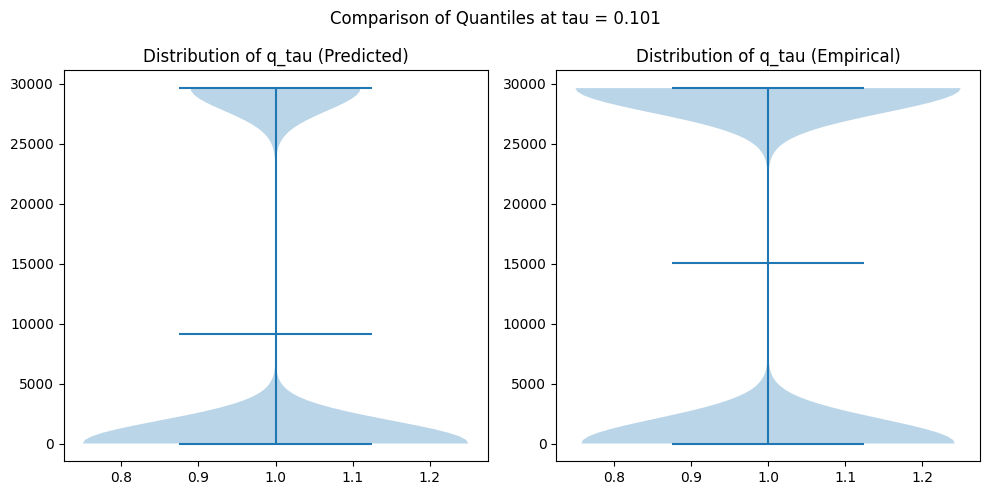

In [3]:
from matplotlib import pyplot as plt
# from scipy.stats.geom import ppf
import scipy

quant_pred = [scipy.stats.geom.ppf(taus[idx], max(item.item() if item.item() > 1e-3 else 1e-20, 36e-7)) for item in pred['proba']]

quant_emp = [scipy.stats.geom.ppf(taus[idx], max(item[1][0], 36e-7)) for item in cal_props]

# Plot the distributions of quant_pred and quant_emp with a violin plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.violinplot(quant_pred, showmeans=True)
plt.title(f"Distribution of q_tau (Predicted)")
plt.subplot(1, 2, 2)
plt.violinplot(quant_emp, showmeans=True)
plt.title(f"Distribution of q_tau (Empirical)")
plt.suptitle(f"Comparison of Quantiles at tau = {taus[idx]:.3f}")
plt.tight_layout()
plt.show()

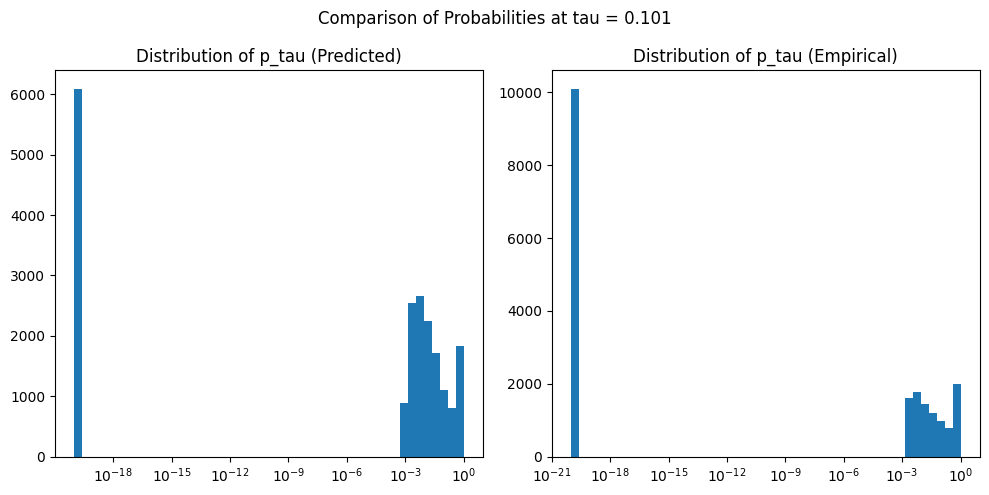

In [4]:
# Now plot the distribution of the probabilities themselves in log scale in x
proba_pred = np.array([item.item() for item in pred['proba']])
proba_pred = np.clip(proba_pred, 1e-20, 1 - 1e-20)  # Avoid log(0) issues
proba_pred[proba_pred < 1e-3] = 1e-20  # Set small values to a minimum threshold
proba_emp = np.array([item[1][0] for item in cal_props])
proba_emp = np.clip(proba_emp, 1e-20, 1 - 1e-20)  # Avoid log(0) issues
# Create logarithmically spaced bins based on the range of the data
bins_pred = np.logspace(np.log10(proba_pred.min()), np.log10(proba_pred.max()), 50)
bins_emp = np.logspace(np.log10(proba_emp.min()), np.log10(proba_emp.max()), 50)

plt.figure(figsize=(10, 5))

# Plot predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(proba_pred, bins=bins_pred)
plt.xscale('log')
plt.title("Distribution of p_tau (Predicted)")

# Plot empirical probabilities
plt.subplot(1, 2, 2)
plt.hist(proba_emp, bins=bins_emp)
plt.xscale('log')
plt.title("Distribution of p_tau (Empirical)")

plt.suptitle(f"Comparison of Probabilities at tau = {taus[idx]:.3f}")
plt.tight_layout()
plt.show()

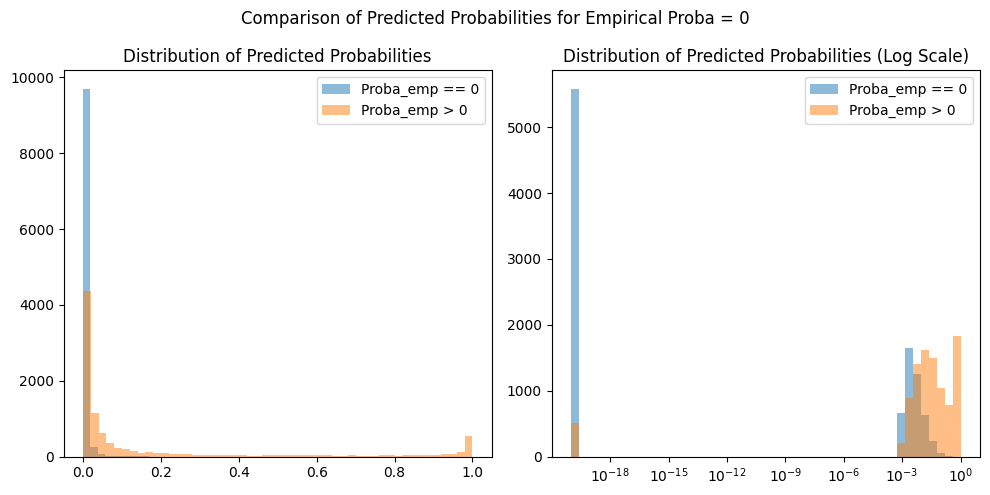

In [5]:
# Check if the samples for which proba_emp == 0 are seperable from the rest based on a threshold on the predicted probabilities
# Get the indices of the samples where proba_emp == 0
zero_indices = np.where(proba_emp < 1e-10)[0]
# Get the predicted probabilities for these samples
zero_pred_probs = proba_pred[zero_indices]
# Get the predicted probabilities for the rest of the samples
non_zero_indices = np.where(proba_emp > 1e-10)[0]
non_zero_pred_probs = proba_pred[non_zero_indices]
# Plot the distributions of the predicted probabilities for both groups
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(zero_pred_probs, bins=50, alpha=0.5, label='Proba_emp == 0')
plt.hist(non_zero_pred_probs, bins=50, alpha=0.5, label='Proba_emp > 0')
plt.legend()
plt.title("Distribution of Predicted Probabilities")
# Now in log scale
plt.subplot(1, 2, 2)
plt.hist(zero_pred_probs, bins=bins_pred, alpha=0.5, label='Proba_emp == 0')
plt.hist(non_zero_pred_probs, bins=bins_pred, alpha=0.5, label='Proba_emp > 0')
plt.xscale('log')
plt.legend()
plt.title("Distribution of Predicted Probabilities (Log Scale)")
plt.suptitle(f"Comparison of Predicted Probabilities for Empirical Proba = 0")
plt.tight_layout()

In [6]:
# Create generation and rating backends
from src.rating.detoxify import DetoxifyRater
from src import utils
from src.generation.vanilla_model_hf import VanillaGeneratorHF
from src.survival_runner import (
    SurvivalRunner,
    SurvivalResult,
    default_toxicity_func,
    default_text_prep_func,
)

# Create the parameter dictionary for the rating backend.
rater_params = {
    "model_type": "original",
    "amp": True,
}

# Get the Hugging Face key.
hf_key = utils.api_key_from_file("HF_KEY.txt")

# Create the parameter dictionary for the generation backend.
generator_params = {
    "model_name": "meta-llama/Llama-3.2-3B",
    "hub_token": hf_key,
    "max_input_tokens": 40,
    "max_output_tokens": 30,
    "torch_dtype": torch.bfloat16,
    # If you need to specify the attention implementation, uncomment the line below.
    # "attn_implementation": "flash_attention_2",
}

In [8]:
# Force reimport
import importlib
import src.conformal
importlib.reload(src.conformal)
from src.conformal import conformalize

trainer = pl.Trainer()
target_taus = torch.tensor([0.1])
canidate_taus = torch.tensor(np.logspace(-9, -1, 200))

tau_hat, max_est, q_hat = conformalize(trainer=trainer, model=model, target_taus=target_taus, canidate_taus=canidate_taus, X=cal_prompts, generator_params=generator_params, rater_params=rater_params, 
                              budget_per_sample=20, share_budget=True, min_sample_size=0.5, text_prep_func="sentence_completion", multi_gpu=True)

Trainer will use only 1 of 5 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=5)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting: |          | 0/? [00:00<?, ?it/s]

Currently using GPU ID for survival sampling: 1
Length of prompts_chunk: 3978
Currently using GPU ID for survival sampling: 3
Length of prompts_chunk: 3977
Currently using GPU ID for survival sampling: 2
Length of prompts_chunk: 3978
Currently using GPU ID for survival sampling: 0
Length of prompts_chunk: 3978
Currently using GPU ID for survival sampling: 4
Length of prompts_chunk: 3977
INFO 04-15 10:52:12 [__init__.py:239] Automatically detected platform cuda.
INFO 04-15 10:52:12 [__init__.py:239] Automatically detected platform cuda.
INFO 04-15 10:52:12 [__init__.py:239] Automatically detected platform cuda.
INFO 04-15 10:52:12 [__init__.py:239] Automatically detected platform cuda.
INFO 04-15 10:52:12 [__init__.py:239] Automatically detected platform cuda.
INFO: Overhead tokens:  100
INFO: Empty input tokens:  1
INFO: Total sequence tokens:  71
INFO: Overhead tokens:  100
INFO: Empty input tokens:  1
INFO: Total sequence tokens:  71
INFO: Overhead tokens:  100
INFO: Empty input toke

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO 04-15 10:52:29 [core.py:61] Initializing a V1 LLM engine (v0.8.4) with config: model='meta-llama/Llama-3.2-3B', speculative_config=None, tokenizer='meta-llama/Llama-3.2-3B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=171, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=None, served_model_name=meta-llama/Llama-3.2-3B, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=True, chunked_prefill_enabled=True, use_asyn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO 04-15 10:52:29 [core.py:61] Initializing a V1 LLM engine (v0.8.4) with config: model='meta-llama/Llama-3.2-3B', speculative_config=None, tokenizer='meta-llama/Llama-3.2-3B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=171, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=None, served_model_name=meta-llama/Llama-3.2-3B, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=True, chunked_prefill_enabled=True, use_asyn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO 04-15 10:52:30 [core.py:61] Initializing a V1 LLM engine (v0.8.4) with config: model='meta-llama/Llama-3.2-3B', speculative_config=None, tokenizer='meta-llama/Llama-3.2-3B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=171, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=None, served_model_name=meta-llama/Llama-3.2-3B, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=True, chunked_prefill_enabled=True, use_asyn

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  4.22it/s]
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 04-15 10:52:32 [weight_utils.py:265] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  5.87it/s]
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.12it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.29it/s]



INFO 04-15 10:52:33 [loader.py:458] Loading weights took 0.98 seconds


Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  4.56it/s]
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 04-15 10:52:33 [gpu_model_runner.py:1291] Model loading took 6.0160 GiB and 2.235955 seconds


Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  1.84it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.05it/s]

Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  3.50it/s]
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 04-15 10:52:33 [loader.py:458] Loading weights took 1.17 seconds


Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  2.99it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.50it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.66it/s]



INFO 04-15 10:52:34 [gpu_model_runner.py:1291] Model loading took 6.0160 GiB and 2.650292 seconds
INFO 04-15 10:52:34 [loader.py:458] Loading weights took 1.32 seconds


Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.49it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.63it/s]



INFO 04-15 10:52:34 [gpu_model_runner.py:1291] Model loading took 6.0160 GiB and 3.148340 seconds
INFO 04-15 10:52:34 [loader.py:458] Loading weights took 1.33 seconds


Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.74it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.86it/s]



INFO 04-15 10:52:34 [loader.py:458] Loading weights took 1.20 seconds
INFO 04-15 10:52:34 [gpu_model_runner.py:1291] Model loading took 6.0160 GiB and 3.205066 seconds
INFO 04-15 10:52:35 [gpu_model_runner.py:1291] Model loading took 6.0160 GiB and 3.616403 seconds
INFO 04-15 10:52:40 [backends.py:416] Using cache directory: /home/dahen/.cache/vllm/torch_compile_cache/1cfc09fc1e/rank_0_0 for vLLM's torch.compile
INFO 04-15 10:52:40 [backends.py:426] Dynamo bytecode transform time: 7.37 s
INFO 04-15 10:52:41 [backends.py:115] Directly load the compiled graph for shape None from the cache
INFO 04-15 10:52:41 [backends.py:416] Using cache directory: /home/dahen/.cache/vllm/torch_compile_cache/1cfc09fc1e/rank_0_0 for vLLM's torch.compile
INFO 04-15 10:52:41 [backends.py:426] Dynamo bytecode transform time: 7.64 s
INFO 04-15 10:52:41 [backends.py:416] Using cache directory: /home/dahen/.cache/vllm/torch_compile_cache/1cfc09fc1e/rank_0_0 for vLLM's torch.compile
INFO 04-15 10:52:41 [backends

Processing Prompts:   0%|          | 0/3978 [00:00<?, ?it/s]

INFO 04-15 10:53:24 [gpu_model_runner.py:1626] Graph capturing finished in 29 secs, took 1.41 GiB
INFO 04-15 10:53:24 [core.py:163] init engine (profile, create kv cache, warmup model) took 49.66 seconds
INFO 04-15 10:53:24 [core_client.py:435] Core engine process 0 ready.
INFO 04-15 10:53:24 [gpu_model_runner.py:1626] Graph capturing finished in 29 secs, took 1.41 GiB
INFO 04-15 10:53:24 [core.py:163] init engine (profile, create kv cache, warmup model) took 50.26 seconds
INFO 04-15 10:53:24 [core_client.py:435] Core engine process 0 ready.
INFO 04-15 10:53:24 [gpu_model_runner.py:1626] Graph capturing finished in 29 secs, took 1.41 GiB
INFO 04-15 10:53:24 [core.py:163] init engine (profile, create kv cache, warmup model) took 49.59 seconds
INFO 04-15 10:53:24 [core_client.py:435] Core engine process 0 ready.
INFO 04-15 10:53:24 [gpu_model_runner.py:1626] Graph capturing finished in 30 secs, took 1.41 GiB
INFO 04-15 10:53:24 [core.py:163] init engine (profile, create kv cache, warmup 

Processing Prompts: 100%|██████████| 3978/3978 [07:04<00:00,  9.37it/s, batch_num=64, batch_time=0.53, time_remaining=0:00:00]          


[[2.00000001 2.00000001 2.00000001 ... 2.00000001 2.00000001 2.00000001]
 [2.00000001 2.00000001 2.00000001 ... 2.00000001 2.00000001 2.00000001]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [2.00000001 2.00000001 2.00000001 ... 2.00000001 2.00000001 2.00000001]
 [2.00000001 2.00000001 2.00000001 ... 2.00000001 2.00000001 2.00000001]
 [2.00000001 2.00000001 2.00000001 ... 2.00000001 2.00000001 2.00000001]]
[[1 1 1 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0.17820877 0.18145816 0.18409829 0.18643379 0.18937855 0.19151097
 0.19374492 0.19729894 0.20004062 0.20318846 0.20532088 0.20816409
 0.21039805 0.21293664 0.21649066 0.21791227 0.22014622 0.22380179
 0.22684809 0.23009748 0.2329407  0.2352762  0.23822096 0.24116572
 0.24370431 0.24675061 0.2507108  0.25335093 0.25639724 0.2600528
 0.26259139 0.26421608 0.26726239 0.27020715 0.27345654 0.27650284
 0.27893989 0.28279854 0.28625102 0

In [ ]:
print(tau_hat)
print(max_est)
# Print the average prediction for tau=tau_hat
idx_tau_hat = (taus - tau_hat).abs().argmin()
print("Average prediction for tau=tau_hat:", torch.mean(torch.minimum(torch.stack([item['tau'][idx_tau_hat] for item in pred]), torch.tensor(max_est))))
print("Average prediction for tau=0.1:", torch.mean(torch.stack([item['tau'][idx] for item in pred])))

# Plot the distribution of [item['tau'][idx_tau_hat].item() for item in pred]
plt.hist(q_hat, bins=50)
plt.xlabel("Tau")
plt.ylabel("Frequency")
plt.title("Distribution of Tau")
plt.show()